In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import rasterio as rs
import cartopy
import os
import pyproj
from rasterio import mask
import shapely
import pandas as pd
import seaborn as sns

In [2]:
## create a class to allow for easy generation of maps, files, and dataframes
class map_generator:
    def __init__(self, list_files):
        self.file_names=list_files
     
    ## finds the max windspeed of a given year. returns a nc file
    def agg_max(self,year):
        map_files=[file for file in self.file_names if file[-9:-5]==year]
        for i,file in enumerate(map_files):
            fp=xr.open_dataset(file)
            if i==0:
                max_mag=fp.max(dim=['Time'])
            else:
                max_mag_month=fp.max(dim=['Time'])
                max_mag=xr.concat([max_mag,max_mag_month],dim='Time')
        max_value=max_mag.max(dim=['Time'])['mag']
        return max_value
    
    ## finds the mean wind speed of a given year. returns an nc file
    def agg_mean(self,year):
        map_files=[file for file in self.file_names if file[-9:-5]==year]
        for i,file in enumerate(map_files):
            fp=xr.open_dataset(file)
            if i==0:
                mean_mag=fp.mean(dim=['Time'])
            else:
                mean_mag_month=fp.mean(dim=['Time'])
                mean_mag=xr.concat([mean_mag,mean_mag_month],dim='Time')
        mean_value=mean_mag.max(dim=['Time'])['mag']
        return mean_value
    
    ## converts nc to tif file. nc file must be only one time step
    def dem_to_tif(self,dem,output_file='/shared_space/ACV/tif_files/placeholder.tif'):
        nc_file='/shared_space/ACV/inter_files/nc_to_translate.nc'
        inter_file='/shared_space/ACV/inter_files/inter_file.tif'
        output_file='/shared_space/ACV/inter_files/output_file.tif'
        if os.path.exists(nc_file):
            os.remove(nc_file)
        if os.path.exists(inter_file):
            os.remove(inter_file)
        dem.to_netcdf(nc_file)
        string_1="gdal_translate -a_srs '+proj=lcc +a=6370000 +b=6370000 +lon_0=-97.899994 +lat_0=39.100006 +lat_1=30.0 +lat_2=50.0 +datum=WGS84 +units=m +no_defs' -a_ullr 1144000.0 8000.0 2084000.0 -528000.0 %s %s"
        string_2="gdalwarp -overwrite -r average -s_srs '+proj=lcc +a=6370000 +b=6370000 +lon_0=-97.899994 +lat_0=39.100006 +lat_1=30.0 +lat_2=50.0 \
        +datum=WGS84 +units=m +no_defs' -t_srs EPSG:4326 %s %s"
        os.system(string_1%(nc_file,inter_file))
        os.system(string_2%(inter_file,output_file))
        return rs.open(output_file)
    
    ## plots tif file and intersects countys on plot. Prints intersected df as well
    def plotter(self,year,max_mean,county=True):
        if max_mean=='max':
            agg_dem=self.agg_max(year)
            print_type='Max'
        elif max_mean=='mean':
            agg_dem=self.agg_mean(year)
            print_type='Mean'
        else:
            print('cannot plot max_mean')

        plot_fp=all_data.dem_to_tif(agg_dem)
        dem=plot_fp.read(1)
        extent=[plot_fp.bounds[0],plot_fp.bounds[2],plot_fp.bounds[1],plot_fp.bounds[3]]
        
        county_fp=gpd.read_file('/shared_space/ACV/county_shp/NCDOT_County_Boundaries.shp')
        county_fp=county_fp.to_crs('EPSG:4326')
        county_fp['geometry'] = county_fp['geometry'].apply(lambda geometry: shapely.ops.transform(lambda x, y: (y, x), geometry))

        #extent=[lons.min(), lons.max(), lats.min(), lats.max()]
        fig,ax=plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.imshow(dem, transform=ccrs.PlateCarree(), cmap='viridis',origin='upper',extent=extent) 
        ax.set_title('%s %s Wind Speed'%(year,print_type))   
        if county==True:
            ax.add_geometries(county_fp.geometry, crs = ccrs.PlateCarree(),edgecolor = 'black',facecolor='none')
        plt.show()
        
        ## intersect the shapefile with the tif
        output_arrays=county_fp.apply(lambda x: mask.mask(plot_fp, [x['geometry']])[0][0,:,:],axis=1)
        output_arrays = output_arrays.apply(lambda arr: np.nan_to_num(arr, nan=-99999))

        speeds={}
        for i,county in enumerate(output_arrays):
            speeds[county_fp['CountyName'][i]]=plot_fp.read(1)[output_arrays[i]!=-99999]
    
        results_df=pd.DataFrame([])
        results_df['County']=list(speeds.keys())
        results_df['mean']=results_df.apply(lambda x: np.mean(speeds[x['County']]),axis=1)
        results_df['max']=results_df.apply(lambda x: np.mean(speeds[x['County']]),axis=1)
        
        return results_df
        
cdf_list=glob.glob('/shared_space/ACV/extracted_raw/mag_dir/*')
all_data=map_generator(cdf_list)

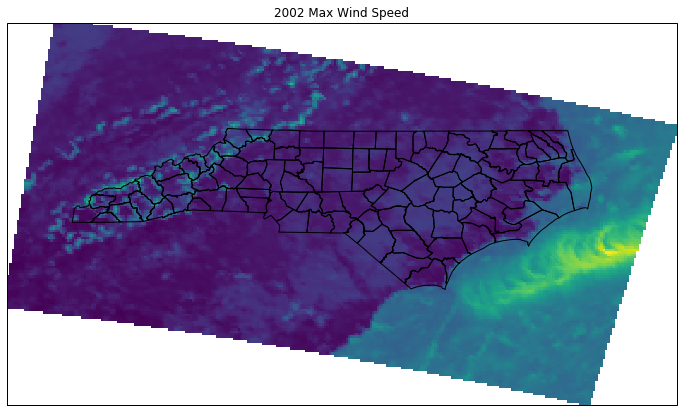

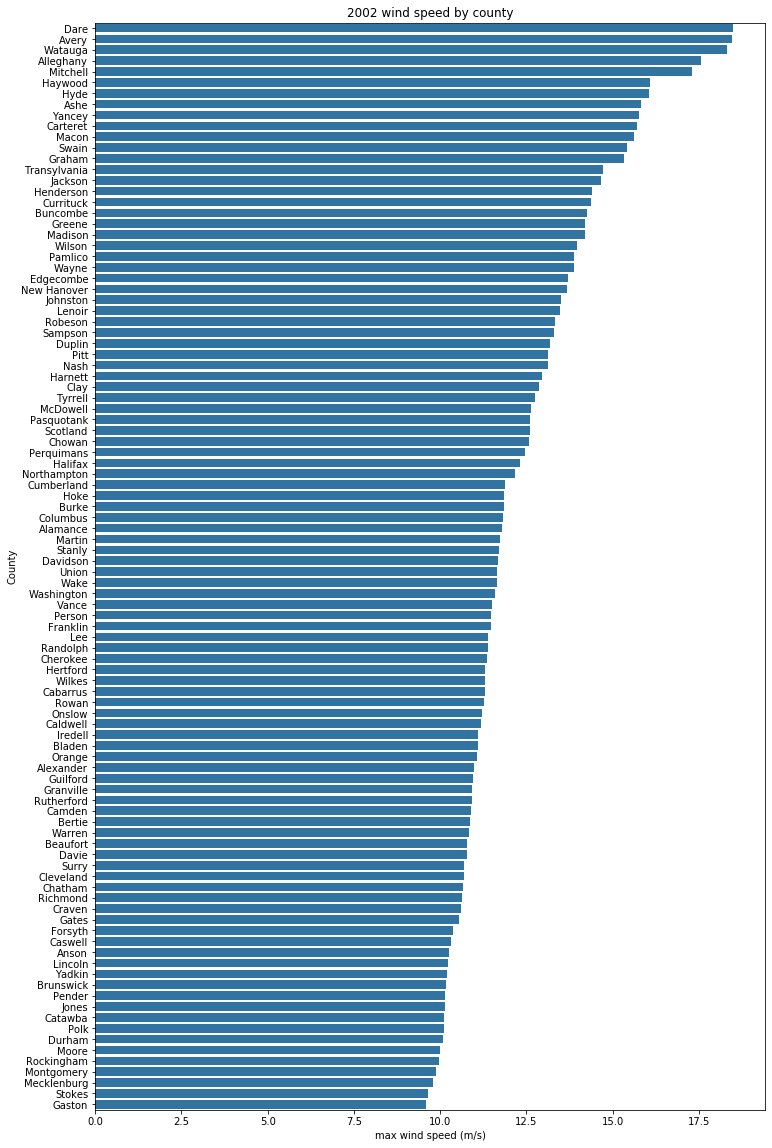

In [4]:
## code to plot specified years windspeed. Also pull a dataframe of the windspeed by county stored in results_df

## Change code here: specify what year you want if if you want max or mean wind speeds
## must be spring
year_of_interest='2002'
agg_type='max'

results_df=all_data.plotter(year_of_interest,agg_type)

fig, ax = plt.subplots(figsize=(12, 20))
ax=sns.barplot(data=results_df.sort_values(by='mean',ascending=False),x='mean',y='County',color='tab:blue')
ax.set_title('%s wind speed by county'% year_of_interest)
ax.set_xlabel('%s wind speed (m/s)'%agg_type)
plt.show()